In [4]:
from regression4 import training_run, Config
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from models import LinearBSpline

import torch
import utils
import importlib
importlib.reload(utils)

mparams = Config(
    layers = [8],
    cpoints = 3,
    range_ = 1,
)
            
tparams = Config(
    relu_epochs = 50,
    spline_epochs = 200,
    both_epochs = 0,
    batch_size = 10,
    lr_wb = 0.001,
    lr_bs = 0.001,
    lrs = "steplr",
    lrs_gamma = .9,
    lrs_stepsize = 5
)

model = LinearBSpline(mparams.layers, mparams.cpoints, mparams.range_)

torch.set_num_threads(1)

# Load the data
housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

train_history, val_history, epoch_times, training_time, fwd_lat, model, final_locs, final_coeffs = training_run(mparams, tparams, X, y)

/home/wpatty/.conda/envs/dsnn_liam_py3.10/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


tensor([-1.,  0.,  1.])
tensor([-0.0206, -0.0025,  1.2611])


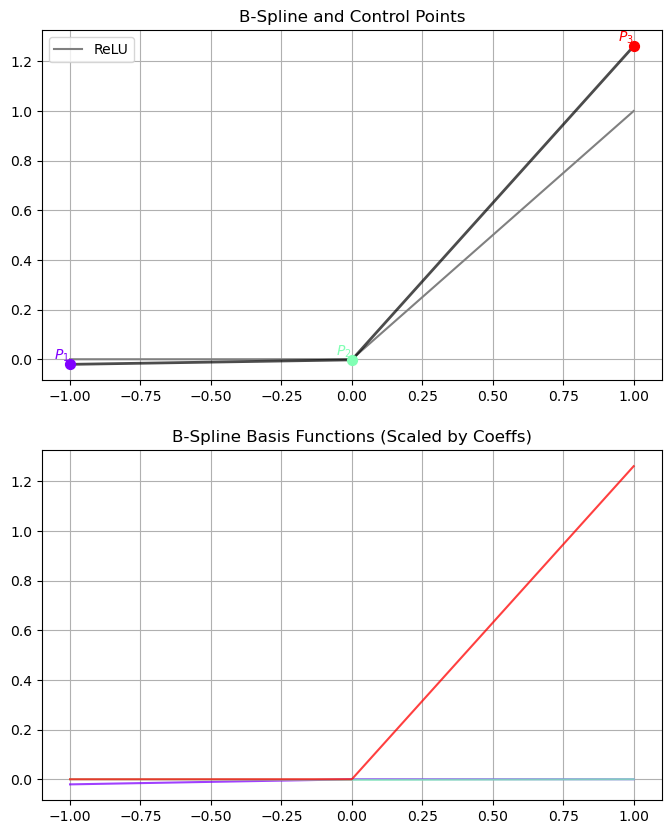

In [7]:
sel = 3

print(final_locs[sel])
print(final_coeffs[sel])

utils.plot_bspline(final_locs[sel], final_coeffs[sel])

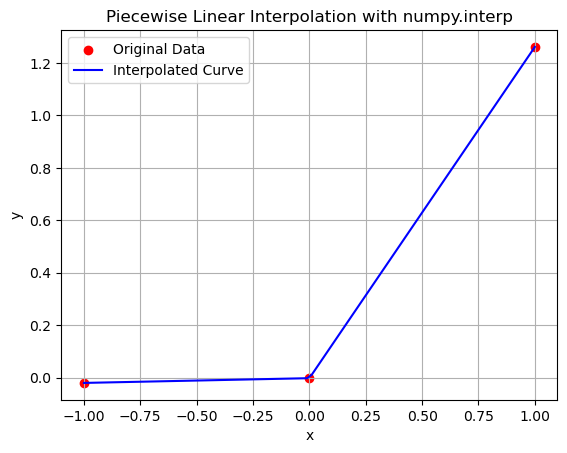

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x = final_locs[sel]
y = final_coeffs[sel]

x_new = np.linspace(x.min(), x.max(), 100)

y_new = np.interp(x_new, x, y)
plt.scatter(x, y, color='red', label='Original Data')
plt.plot(x_new, y_new, color='blue', label='Interpolated Curve')

plt.title('Piecewise Linear Interpolation with numpy.interp')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()
